## Using a Decision Tree Regressor to predict a time series

You don't have to go to ARIMAs or Recurrent Neural Networks to forecast time series data.  This example uses a Decision Tree Regressor to predict increasing CO2 concentrations in Mauna Loa, Hawaii.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

In [2]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})

In [3]:
df = pd.read_csv('./data/Mauna_Loa_monthlymean_CO2.txt', delim_whitespace=True)

In [4]:
df.head()

,year,m,y_decimal,ppm_mean,ppm_int,trend,#days
0,1958,3,1958.208,315.71,315.71,314.62,-1
1,1958,4,1958.292,317.45,317.45,315.29,-1
2,1958,5,1958.375,317.50,317.50,314.71,-1
3,1958,6,1958.458,-99.99,317.10,314.85,-1
4,1958,7,1958.542,315.86,315.86,314.98,-1


### Data comes from the  [NOAA website](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The data we care about is the interpolated ppm, which corrects for missing data, and the year it occured (in decimal format).

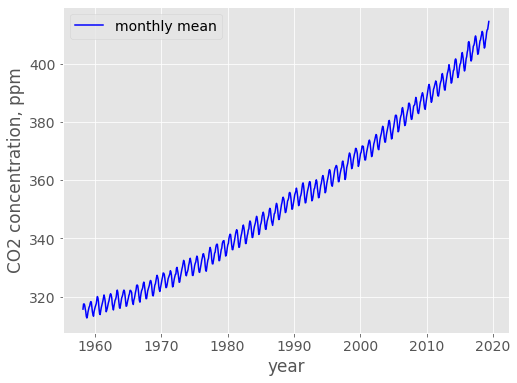

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(df['y_decimal'], df['ppm_int'], c='b', label='monthly mean')
ax.set_xlabel('year')
ax.set_ylabel('CO2 concentration, ppm')
ax.legend();

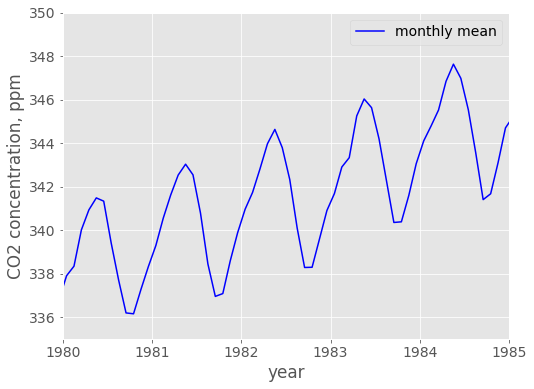

In [6]:
#zoom in to better see behavior
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(df['y_decimal'], df['ppm_int'], c='b', label='monthly mean')
ax.set_xlabel('year')
ax.set_ylabel('CO2 concentration, ppm')
ax.set_xlim((1980, 1985))
ax.set_ylim((335, 350))
ax.legend();

### CO2 Trend and Seasonality
In Mauna Loa there is an obvious yearly trend (increasing) and yearly seasonality (in winter less photosynthesis, so CO2 rises, then CO2 falls as photosynthesis increases in summer).

Let's make sure the Decision Tree Regressor has both the year and month as features, and the ppm as the target.

We'll split off 2010-2019 as our hold-out set.

In [7]:
year_cutoff = 2000
columns = ['year','m', 'ppm_int']
train_mask = df['year'] < year_cutoff
holdout_mask = df['year'] >= year_cutoff
df_train = df[train_mask][columns]
df_holdout = df[holdout_mask][columns]

view = 26
print("Train")
print(df_train.head(view))
print("\n")
print("Holdout")
print(df_holdout.head(view))

Train
    year   m  ppm_int
0   1958   3   315.71
1   1958   4   317.45
2   1958   5   317.50
3   1958   6   317.10
4   1958   7   315.86
5   1958   8   314.93
6   1958   9   313.20
7   1958  10   312.66
8   1958  11   313.33
9   1958  12   314.67
10  1959   1   315.62
11  1959   2   316.38
12  1959   3   316.71
13  1959   4   317.72
14  1959   5   318.29
15  1959   6   318.15
16  1959   7   316.54
17  1959   8   314.80
18  1959   9   313.84
19  1959  10   313.26
20  1959  11   314.80
21  1959  12   315.58
22  1960   1   316.43
23  1960   2   316.97
24  1960   3   317.58
25  1960   4   319.02


Holdout
     year   m  ppm_int
502  2000   1   369.29
503  2000   2   369.55
504  2000   3   370.60
505  2000   4   371.82
506  2000   5   371.58
507  2000   6   371.70
508  2000   7   369.86
509  2000   8   368.13
510  2000   9   367.00
511  2000  10   367.03
512  2000  11   368.37
513  2000  12   369.67
514  2001   1   370.59
515  2001   2   371.51
516  2001   3   372.43
517  2001   4   373.37

### The feature window

Looking at the initial figure, it looks like the trend is mostly linear, with slight exponential growth behavior.  If we use a feature window the length of 12 months it should capture the monthly behavior, and then we'll transform our features and target by the mean of the values in the 12 month window.  This should effectively detrend the data.

In [8]:
months_back = 12  # how far back we are looking to predict the future

### Not demeaned

Let's look at the features corresponding to one training row, before demeaning the data.

In [9]:
def training_row_not_dm(df, months_back,year_of_pred, month_of_pred):
    '''Makes the training window dataframe based on how many
       months back, the year you wish to predict, and the
       month you wish to predict.
       Does not demean data.'''
    column_names = ['minus_'+str(i) for i in range(months_back, 0, -1)]
    column_names.extend(['month', 'year','target'])
    row_target = df.loc[(df['year'] == year_of_pred) & (df['m'] == month_of_pred)]
    yt = row_target['ppm_int'].values[0]
    row_last = row_target.index[0] 
    row_first = row_last - months_back + 1 
    df_roi = df.loc[row_first-1:row_last-1,:]
    ppm_vals = list(df_roi['ppm_int'].values)
    ppm_vals.extend([month_of_pred, year_of_pred, yt])
    df_window = pd.DataFrame(columns=column_names)
    df_window.loc[0] = ppm_vals
    return df_window

df_row = training_row_not_dm(df_train, months_back, 1960, 4)
df_row.head()

,minus_12,minus_11,minus_10,minus_9,minus_8,minus_7,minus_6,minus_5,minus_4,minus_3,minus_2,minus_1,month,year,target
0,317.72,318.29,318.15,316.54,314.8,313.84,313.26,314.8,315.58,316.43,316.97,317.58,4.0,1960.0,319.02


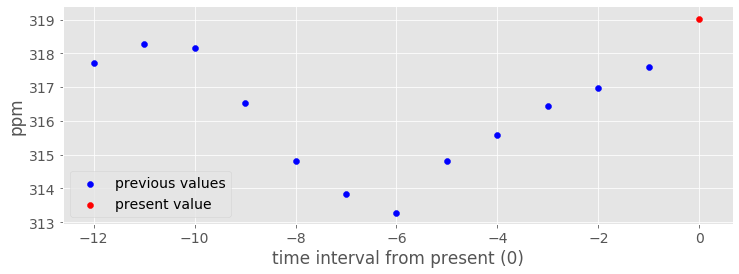

In [10]:
def plot_row_lookback(df, months_back):
    times = list(range(-months_back,0))
    vals = list(df.iloc[0].values[0:months_back])
    val_y = df.iloc[0].values[-1]
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.scatter(times,vals, c='b', label='previous values')
    ax.scatter(0, val_y, c='r', label='present value')
    ax.set_xlabel('time interval from present (0)')
    ax.set_ylabel('ppm')
    ax.legend()

plot_row_lookback(df_row, months_back)

### Demeaned  

After reading in the 12 previous values, we'll calculate the mean and subtract the mean from each value.  We'll also subtract it from the target.

In [11]:
def training_row(df, months_back,year_of_pred, month_of_pred):
    '''Makes the training window dataframe based on how many
       months back, the year you wish to predict, and the
       month you wish to predict'''
    column_names = ['minus_'+str(i) for i in range(months_back, 0, -1)]
    column_names.extend(['month', 'year', 'target', 'ppm_mean', 'ppm_target'])
    row_target = df.loc[(df['year'] == year_of_pred) & (df['m'] == month_of_pred)]
    yt = row_target['ppm_int'].values[0]
    row_last = row_target.index[0]
    row_first = row_last - months_back + 1
    df_roi = df.loc[row_first-1:row_last-1,:]
    ppm_raw = list(df_roi['ppm_int'].values)
    ppm_mean = np.mean(ppm_raw)
    ppm_demeaned = [val - ppm_mean for val in ppm_raw]
    yt_demeaned = yt - ppm_mean
    ppm_demeaned.extend([month_of_pred, year_of_pred, yt_demeaned, ppm_mean, yt])
    df_window = pd.DataFrame(columns=column_names)
    df_window.loc[0] = ppm_demeaned
    return df_window

df_row = training_row(df_train, months_back, 1960, 1)
df_row.head()

,minus_12,minus_11,minus_10,minus_9,minus_8,minus_7,minus_6,minus_5,minus_4,minus_3,minus_2,minus_1,month,year,target,ppm_mean,ppm_target
0,-0.354167,0.405833,0.735833,1.745833,2.315833,2.175833,0.565833,-1.174167,-2.134167,-2.714167,-1.174167,-0.394167,1.0,1960.0,0.455833,315.974167,316.43


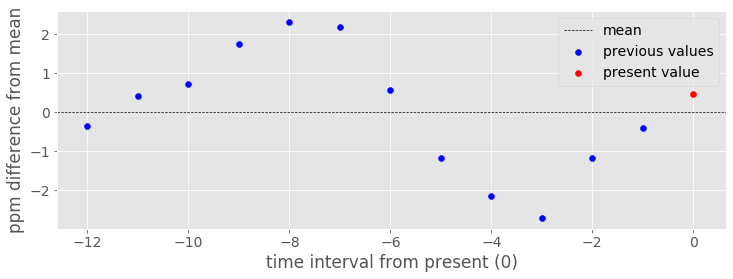

In [12]:
def plot_row_lookback_demeaned(df, months_back):
    times = list(range(-months_back,0))
    vals = list(df.iloc[0].values[0:months_back])
    val_y = df.iloc[0].values[-3]
    #vals.extend([val_y])
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.scatter(times,vals, c='b', label='previous values')
    ax.scatter(0, val_y, c='r', label='present value')
    ax.axhline(0, c='k', linestyle='--', linewidth=0.7, label='mean')
    ax.set_xlabel('time interval from present (0)')
    ax.set_ylabel('ppm difference from mean')
    ax.legend()


plot_row_lookback_demeaned(df_row, months_back)

### Let's make a dataset to train on using demeaned approach

In [13]:
def make_Xy(df, year_start, year_end, window_size):
    '''Takes dataframe and makes it into time series training matrix
       from year_start to year_end, where there are window size
       values back in time for each row
    '''
    column_names = ['minus_'+str(i) for i in range(months_back, 0, -1)]
    column_names.extend(['month', 'year', 'target', 'ppm_mean', 'ppm_target'])
    df_Xy_train = pd.DataFrame(columns=column_names)
    years = range(year_start, year_end)
    months = range(1, 13)
    for year in years:
        for month in months:
            df_row = training_row(df, window_size,year, month)
            df_Xy_train = pd.concat([df_Xy_train, df_row])
    df_Xy_train.reset_index(inplace=True)
    df_Xy_train.drop(columns='index', inplace=True)
    return df_Xy_train    

In [14]:
months_back = 12
df_Xy_train = make_Xy(df_train, 1965, 1970, months_back)  # 5 year dataset, always looking back 12 month

In [15]:
df_Xy_train

,minus_12,minus_11,minus_10,minus_9,minus_8,minus_7,minus_6,minus_5,minus_4,minus_3,minus_2,minus_1,month,year,target,ppm_mean,ppm_target
0,-0.047500,0.452500,1.112500,2.152500,2.632500,2.272500,0.822500,-0.917500,-2.917500,-2.827500,-1.827500,-0.907500,1.0,1965.0,-0.177500,319.617500,319.44
1,0.463333,1.123333,2.163333,2.643333,2.283333,0.833333,-0.906667,-2.906667,-2.816667,-1.816667,-0.896667,-0.166667,2.0,1965.0,0.833333,319.606667,320.44
2,1.092500,2.132500,2.612500,2.252500,0.802500,-0.937500,-2.937500,-2.847500,-1.847500,-0.927500,-0.197500,0.802500,3.0,1965.0,1.252500,319.637500,320.89
3,2.119167,2.599167,2.239167,0.789167,-0.950833,-2.950833,-2.860833,-1.860833,-0.940833,-0.210833,0.789167,1.239167,4.0,1965.0,2.479167,319.650833,322.13
4,2.569167,2.209167,0.759167,-0.980833,-2.980833,-2.890833,-1.890833,-0.970833,-0.240833,0.759167,1.209167,2.449167,5.0,1965.0,2.479167,319.680833,322.16
5,2.216667,0.766667,-0.973333,-2.973333,-2.883333,-1.883333,-0.963333,-0.233333,0.766667,1.216667,2.456667,2.486667,6.0,1965.0,2.196667,319.673333,321.87
6,0.768333,-0.971667,-2.971667,-2.881667,-1.881667,-0.961667,-0.231667,0.768333,1.218333,2.458333,2.488333,2.198333,7.0,1965.0,1.718333,319.671667,321.39
7,-1.050833,-3.050833,-2.960833,-1.960833,-1.040833,-0.310833,0.689167,1.139167,2.379167,2.409167,2.119167,1.639167,8.0,1965.0,-0.940833,319.750833,318.81
8,-3.060000,-2.970000,-1.970000,-1.050000,-0.320000,0.680000,1.130000,2.370000,2.400000,2.110000,1.630000,-0.950000,9.0,1965.0,-1.950000,319.760000,317.81
9,-3.062500,-2.062500,-1.142500,-0.412500,0.587500,1.037500,2.277500,2.307500,2.017500,1.537500,-1.042500,-2.042500,10.0,1965.0,-2.552500,319.852500,317.30


## Let's try training a model on just this data

In [16]:
y_train = df_Xy_train.pop('target').values
y_train_ppm = df_Xy_train.pop('ppm_target').values
X_train_ppm_mean = df_Xy_train.pop('ppm_mean').values
X_train = df_Xy_train.values
X_train[0]

array([-4.7500e-02,  4.5250e-01,  1.1125e+00,  2.1525e+00,  2.6325e+00,
        2.2725e+00,  8.2250e-01, -9.1750e-01, -2.9175e+00, -2.8275e+00,
       -1.8275e+00, -9.0750e-01,  1.0000e+00,  1.9650e+03])

In [17]:
from sklearn.tree import DecisionTreeRegressor

In [18]:
dtr = DecisionTreeRegressor(max_depth=5) # no cross validation, hyperparameter tuning
dtr.fit(X_train,y_train)
y_pred_train = dtr.predict(X_train)
dtr.score(X_train, y_train)

0.9963578440243911

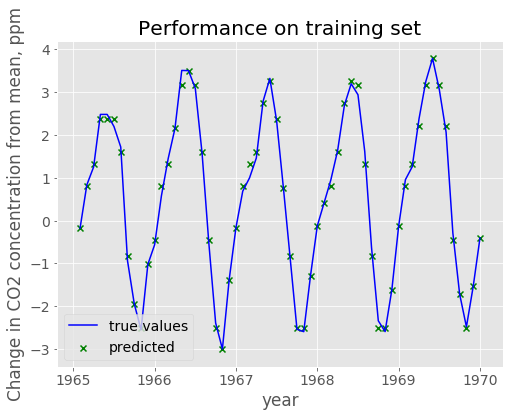

In [19]:
year_train = df_Xy_train['year'] + df_Xy_train['month']/12

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_train, y_train, c='b', label='true values')
ax.scatter(year_train, y_pred_train, marker='x', c='g', label='predicted')
ax.set_xlabel('year')
ax.set_ylabel('Change in CO2 concentration from mean, ppm')
ax.set_title('Performance on training set')
ax.legend();

### But the end goal: predicting actual ppm

In [20]:
y_pred_train_ppm = X_train_ppm_mean + y_pred_train

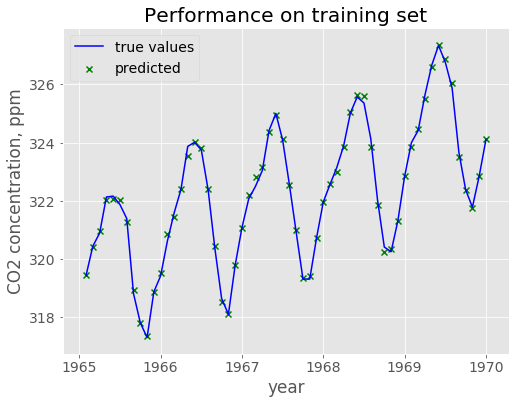

In [21]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_train, y_train_ppm, c='b', label='true values')
ax.scatter(year_train, y_pred_train_ppm, marker='x', c='g', label='predicted')
ax.set_xlabel('year')
ax.set_ylabel('CO2 concentration, ppm')
ax.set_title('Performance on training set')
ax.legend();

In [22]:
rmse_train = np.sqrt(mean_squared_error(y_train_ppm, y_pred_train_ppm))
print(rmse_train)

0.11735956770844892


### Look at test performance

In [23]:
df_Xy_test = make_Xy(df_train.copy(), 1970, 1975, months_back)
y_test = df_Xy_test.pop('target').values
y_test_ppm = df_Xy_test.pop('ppm_target').values
X_test_ppm_mean = df_Xy_test.pop('ppm_mean').values
X_test = df_Xy_test.values

In [24]:
y_pred_test = dtr.predict(X_test)
dtr.score(X_test, y_test)

0.8695329650274227

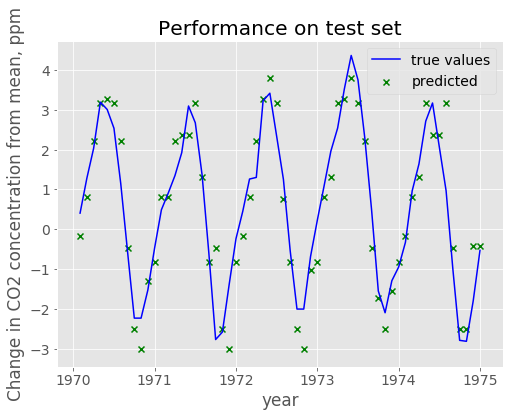

In [25]:
year_test = df_Xy_test['year'] + df_Xy_test['month']/12

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_test, y_test, c='b', label='true values')
ax.scatter(year_test, y_pred_test, marker='x', c='g', label='predicted')
ax.set_xlabel('year')
ax.set_ylabel('Change in CO2 concentration from mean, ppm')
ax.set_title('Performance on test set')
ax.legend();

In [26]:
y_pred_test_ppm = X_test_ppm_mean + y_pred_test

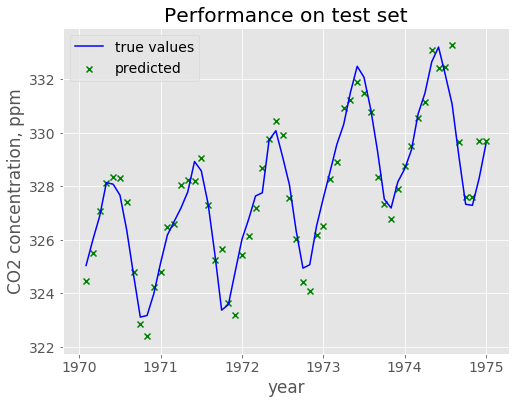

In [27]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_test, y_test_ppm, c='b', label='true values')
ax.scatter(year_test, y_pred_test_ppm, marker='x', c='g', label='predicted')
ax.set_xlabel('year')
ax.set_ylabel('CO2 concentration, ppm')
ax.set_title('Performance on test set')
ax.legend();

In [28]:
rmse_test = np.sqrt(mean_squared_error(y_test_ppm, y_pred_test_ppm))
print(rmse_test)

0.7006666080621267


## Now that we have confidence in train/test results, go bigger

In [29]:
months_back = 12
year_start = 1965
year_end = 2000
df_Xy_train = make_Xy(df_train, year_start, year_end, months_back)
y_train = df_Xy_train.pop('target').values
y_train_ppm = df_Xy_train.pop('ppm_target').values
X_train_ppm_mean = df_Xy_train.pop('ppm_mean').values
X_train = df_Xy_train.values

dtr = DecisionTreeRegressor(max_depth=5) # no cross validation, hyperparameter tuning
dtr.fit(X_train,y_train)
y_pred_train = dtr.predict(X_train)
dtr.score(X_train, y_train)

0.9811446842454501

In [30]:
year_start = 2001
year_end  = 2018
df_Xy_test = make_Xy(df_holdout, year_start, year_end, months_back)
y_test = df_Xy_test.pop('target').values
y_test_ppm = df_Xy_test.pop('ppm_target').values
X_test_ppm_mean = df_Xy_test.pop('ppm_mean').values
X_test = df_Xy_test.values

y_pred_test = dtr.predict(X_test)
dtr.score(X_test, y_test)

0.9575845042589085

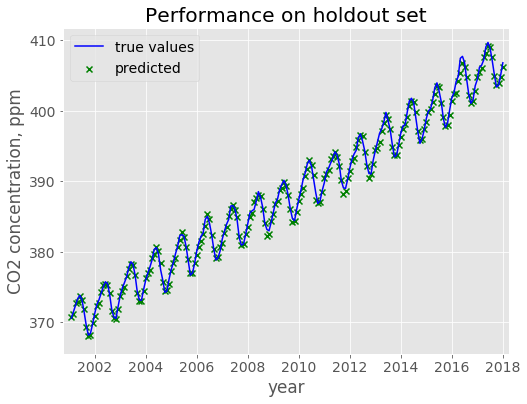

In [31]:
year_test = df_Xy_test['year'] + df_Xy_test['month']/12
y_pred_test_ppm = X_test_ppm_mean + y_pred_test

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_test, y_test_ppm, c='b', label='true values')
ax.scatter(year_test, y_pred_test_ppm, marker='x', c='g', label='predicted')
ax.set_xlabel('year')
ax.set_ylabel('CO2 concentration, ppm')
ax.set_title('Performance on holdout set')
ax.set_xlim((year_start-0.25, year_end+0.25))
ax.legend();

In [32]:
rmse_test = np.sqrt(mean_squared_error(y_test_ppm, y_pred_test_ppm))
print(rmse_test)

0.4588446573871658


### Notes
It should be noted that in all cases here we are using the last known 12 points to predict a 13th point.  This model is not predicting on its predictions.  

For example:  Known ppm in months 1-12 in 2016 are used to predict the ppm of month 1 in 2017.  But then, regardless of what the model predicted for month 1 in 2017, the known value is used to predict the ppm in month 2.

To make a yearly forecast, instead of a monthly forecast, one could predict 2017 month 1, 
then use that value (and the 11 known values of 2016), to predict month 2, and then use the predicted month 1 and month 2 values (and 10 known values from 2016) to predict month 3, and so on.

This is significantly more challenging for the model, and it will not perform as well as demonstrated above!